# Preliminary Classification Using Resampled Dataset
- Exactly the same code as the original nb06_extra2 except the order of train_test split
- train_test split first, train models on resampled train set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

# Preprocess Majority

In [4]:
selection10 = pd.read_csv('./data/select_train_data10.csv')

In [5]:
X = np.array(selection10.iloc[:, :-1])
y = np.array(selection10.iloc[:, -1])

In [6]:
%%time
tl = TomekLinks(n_jobs=8, ratio='majority')
X_tl, y_tl = tl.fit_sample(X, y)

print('Before tomek links: size of X: ', X.shape)
print('After  tomek links: size of X: ', X_tl.shape)
print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

Before tomek links: size of X:  (595212, 35)
After  tomek links: size of X:  (586179, 35)
Before tomek links: class0/class1 = 573518 / 21694
After  tomek links: class0/class1 = 564485 / 21694
CPU times: user 9min 4s, sys: 276 ms, total: 9min 4s
Wall time: 1min 45s


# Undersampling class0 combined with oversampling of class1 by SMOTE

### Set up targets for number of samples for each class, resample training set

In [29]:
rstate = 55
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y_train)
num_class1_to_resample = 3 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_tlrus.shape)

print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_train)-np.sum(y_train), np.sum(y_train)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (586179, 35)
After  Resampling: size of X:  (60844, 35)
Before Resampling: class0/class1 = 395114/ 15211
After  Resampling: class0/class1 =  45633/ 45633


### Run single round of classification with a set random_state for train_test split

======== Random Forest ========
             precision    recall  f1-score   support

          0     0.9667    0.8806    0.9216    169371
          1     0.0621    0.2065    0.0955      6483

avg / total     0.9333    0.8557    0.8912    175854

======== Gradient Boost ========
             precision    recall  f1-score   support

          0     0.9644    0.9791    0.9717    169371
          1     0.0929    0.0560    0.0699      6483

avg / total     0.9323    0.9450    0.9384    175854

CPU times: user 49 s, sys: 128 ms, total: 49.1 s
Wall time: 6.71 s


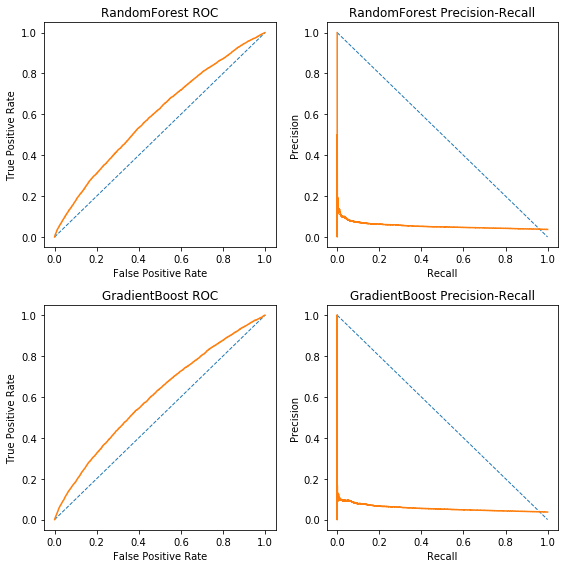

In [30]:
%%time
if True:
    
    fig = plt.figure(figsize=(8, 8))
    neutral_line = np.linspace(0, 1, 10)

    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)
    print('======== Random Forest ========')
    print(report1)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11 = fig.add_subplot(2, 2, 1)
    ax12 = fig.add_subplot(2, 2, 2)
    ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)
    print('======== Gradient Boost ========')
    print(report2)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21 = fig.add_subplot(2, 2, 3)
    ax22 = fig.add_subplot(2, 2, 4)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    plt.tight_layout()

### Run classification multiple rounds with random train_test splitting (try 10 times)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 4min 8s, sys: 449 ms, total: 4min 9s
Wall time: 38.6 s


/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


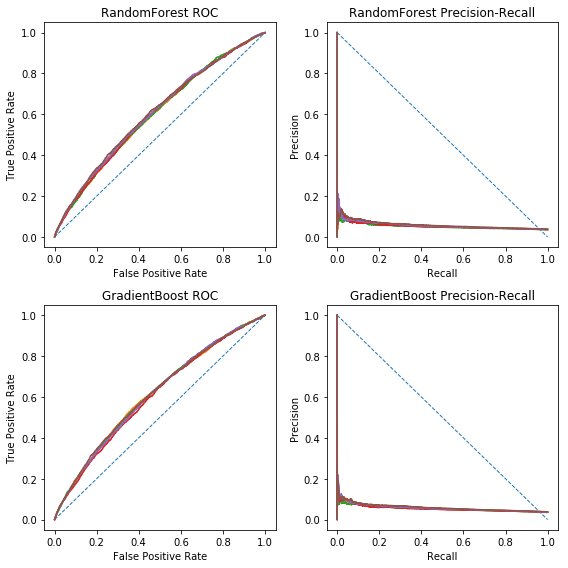

In [31]:
%%time
fig = plt.figure(figsize=(8, 8))
ax11 = fig.add_subplot(2, 2, 1)
ax12 = fig.add_subplot(2, 2, 2)
ax21 = fig.add_subplot(2, 2, 3)
ax22 = fig.add_subplot(2, 2, 4)

neutral_line = np.linspace(0, 1, 10)
ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

for i in range(5):
    
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.1, random_state=rstate)
                                                    
    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)
                                                        
    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    y_pred3 = nb.predict(X_test)
    y_proba3 = nb.predict_proba(X_test)
    report3 = classification_report(y_test, y_pred3, digits=4,
                                   labels=None, target_names=None)

plt.tight_layout()

- All the models are not really dependent on the train_test splits.
- RandomForest and GradientBoost appear most promising

## Conclusion
- Trained model doesn't work so well with the imbalanced set...
- May need to approach differently